In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy import optimize
import networkx as nx
from hashlib import blake2b
from collections import Counter, defaultdict
import itertools
import time
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
#import cvxpy as cp

In [2]:
train_path = "../data/training_data.pkl"
train_labels_path = "../data/training_labels.pkl"
test_path = "../data/test_data.pkl"

with open(train_path, "rb") as f:
    train_data = pickle.load(f)

with open(train_labels_path, "rb") as f:
    train_labels = pickle.load(f)
    
with open(test_path, "rb") as f:
    test_data = pickle.load(f)

f.close()

train_data = np.array(train_data, dtype=object)
train_labels = np.array(train_labels, dtype=int)
test_data = np.array(test_data, dtype=object)

In [3]:
train_labels_svm = train_labels.copy()
train_labels_svm[train_labels_svm == 0] = -1
np.unique(train_labels_svm)

array([-1,  1])

In [4]:
class WLKernel:
    def __init__(self, edge_attr="labels", node_attr="labels", iterations=3):
        self.edge_attr = edge_attr
        self.node_attr = node_attr
        self.n_iter = iterations
    
    def _hash_label(self, label, digest_size):
        return blake2b(label.encode("ascii"), digest_size=digest_size).hexdigest()

    def _neighborhood_aggregate(self, G, node, node_labels):
        """
        Compute new labels for given node by aggregating
        the labels of each node's neighbors.
        """
        label_list = []
        for nbr in G.neighbors(node):
            prefix = "" if self.edge_attr is None else str(G[node][nbr][self.edge_attr])
            label_list.append(prefix + node_labels[nbr])
        return node_labels[node] + "".join(sorted(label_list))

    def weisfeiler_lehman_graph_hash(self, G, digest_size=16):
        def weisfeiler_lehman_step(G, labels):
            """
            Apply neighborhood aggregation to each node
            in the graph.
            Computes a dictionary with labels for each node.
            """
            new_labels = {}
            for node in G.nodes():
                label = self._neighborhood_aggregate(G, node, labels)
                new_labels[node] = self._hash_label(label, digest_size)
            return new_labels

        # set initial node labels
        node_labels = {u: str(dd[self.node_attr]) for u, dd in G.nodes(data=True)}

        subgraph_hash_counts = {}
        for it in range(self.n_iter):
            node_labels = weisfeiler_lehman_step(G, node_labels)
            counter = Counter(node_labels.values())
            # normalize counter
            total = np.sum(list(counter.values()))
            for k in counter:
                counter[k] /= total

            # sort the counter, extend total counts
            subgraph_hash_counts[it] = sorted(counter.items(), key=lambda x: x[0])

        # return _hash_label(str(tuple(subgraph_hash_counts)), digest_size)
        return subgraph_hash_counts
    
    
    def compute_phi(self, Z):
        phi_list = []
        for g in Z:
            phi_list.append(self.weisfeiler_lehman_graph_hash(g))
        return phi_list
    
    def compute_kernel(self, wl1, wl2):
        k = 0
        for i in range(self.n_iter):
            dict1 = dict(wl1[i])
            dict2 = dict(wl2[i])
            # take scalar product only on common keys
            common_keys = set(dict1.keys()).intersection(set(dict2.keys()))
            k += np.sum([dict1[c]*dict2[c] for c in common_keys])
        return k

    def compute_kernel_matrix(self, X, Y):
        # Precompute phi to deal only with dot products
        phi_X = self.compute_phi(X)
        if np.array_equal(X, Y):
            print("Not computing phi again as X=Y")
            phi_Y = phi_X.copy()
        else:
            phi_Y = self.compute_phi(Y)
        ker = np.zeros((len(X), len(Y)))
        count_iter = 0
        if len(X) == len(Y):
            for i in range(len(X)):
                for j in range(i, len(Y)):
                    ker[i, j] = self.compute_kernel(phi_X[i], phi_Y[j])
                    ker[j, i] = ker[i,j]
                count_iter += 1
                if count_iter % 100 == 0:
                    print(f"Iteration {count_iter}")
        else:
            for (i,j) in itertools.product(range(len(X)), range(len(Y))):
                ker[i,j] = self.compute_kernel(phi_X[i], phi_Y[j])
        print("Kernel computed")
        return ker

In [5]:
class KernelPerceptron:
    
    def __init__(self, kernel_mat, epsilon = 1e-3, n_iter=100):
        self.kernel = kernel_mat        
        self.norm_f = None
        self.alpha = None
        self.n_iter = n_iter
        self.training_data = None
        self.weights = None
        self.accuracy = 0
        self.opt_alpha = None
        self.acc_list = []
        self.epsilon = epsilon
    
    def compute_weights(self, y):
        N = len(y)
        w_neg = np.sum(y == -1.)
        w_pos = np.sum(y == 1.)
        self.weights = np.array([N/(2*w_neg) if val==-1. else N/(2*w_pos) for val in y])
        
    def fit(self, X, y, K=None, valX=None, valY=None, K_val=None):
       #### You might define here any variable needed for the rest of the code
        N = len(y)
        if K is None:
            K = self.kernel(X, X)
        self.alpha = np.zeros(N)
        
        # Correct for imbalanceness
        self.compute_weights(y)
        for it in range(self.n_iter):
            #y_pred = np.sign((self.weights*self.alpha).T@K)
            y_pred = np.sign(self.alpha.T@K + self.epsilon)
            for i in range(N):
                if y_pred[i] == y[i]:
                    continue
                self.alpha[i] += y[i]
            if valX is not None:
                #y_pred_val = np.sign((self.weights*self.alpha).T@K_val)
                y_pred_val = np.sign(self.alpha.T@K_val + self.epsilon)
                acc = f1_score(y_pred_val, valY, average="macro")
                self.acc_list.append(acc)
                if acc > self.accuracy:
                    self.accuracy = acc
                    self.opt_alpha = self.alpha.copy()
                    
        self.training_data = X
        
    
    def predict(self, X, K=None):
        """ Predict y values in {-1, 1} """
        if K is None:
            K = self.kernel(self.training_data, X)
        if self.opt_alpha is None:
            return np.sign(self.alpha.T@K + self.epsilon)
        else:
            #return np.sign((self.weights*self.opt_alpha).T@K)
            return np.sign(self.opt_alpha.T@K + self.epsilon)

In [6]:
class KernelLR:
    """ Logistic Regression classifier.
    Parameters:
    -----------
    learning_rate: float
        The step length that will be taken when following the negative gradient during
        training.
    gradient_descent: boolean
        True or false depending if gradient descent should be used when training. If
        false then we use batch optimization by least squares.
    """
    def __init__(self, learning_rate=.1, regul=0):
        self.param = None
        self.learning_rate = learning_rate
        self.regul = regul
        self.accuracy = 0
        self.param_opt = None
        self.acc_list = []
        
    def sigmoid(self, x):
        res = 1/(1 + np.exp(-x))
        return res
    
    def sigmoid_grad(self, x):
        return self.sigmoid(x)*(1 - self.sigmoid(x))

    def fit(self, X, y, valX, valY, n_iter=4000):
        
        # Init params
        n = X.shape[0]
        lim = 1 / np.sqrt(n)
        self.param = np.random.uniform(-lim, lim, (n,))
    
        # Correct for imbalanceness
        w_neg, w_pos = np.bincount(y)
        w_pred = np.array([n/(2*w_neg) if val==0. else n/(2*w_pos) for val in y])
        
        # Run for n_iter epochs
        for i in range(n_iter):
            # Make a new prediction
            y_pred = self.sigmoid(self.param@X)
           
            # Gradient descent step
            self.param = self.param - self.learning_rate * (- X@((y - y_pred)*w_pred) + 2*self.regul*self.param)
           
            # Calculate predictions on validation data
            val_pred = np.round(self.sigmoid(self.param@valX)).astype(int)
            acc = f1_score(valY, val_pred, average="macro")
            self.acc_list.append(acc)
            if acc > self.accuracy:
                self.accuracy = acc
                self.param_opt = self.param.copy()
            
            
    def predict(self, X):
        y_pred = np.round(self.sigmoid(self.param_opt@X)).astype(int)
        return y_pred

In [7]:
class KernelLRCVX:
    """ Logistic Regression classifier.
    Parameters:
    -----------
    learning_rate: float
        The step length that will be taken when following the negative gradient during
        training.
    gradient_descent: boolean
        True or false depending if gradient descent should be used when training. If
        false then we use batch optimization by least squares.
    """
    def __init__(self):
        self.param_opt = None
        
    def sigmoid(self, x):
        res = 1/(1 + np.exp(-x))
        return res

    def fit(self, X, y, n_iter=4000):
        
        # Init params
        m, n = X.shape
    
        # Correct for imbalanceness
        w_neg, w_pos = np.bincount(y)
        w_pred = np.array([n/(2*w_neg) if val==0. else n/(2*w_pos) for val in y])
          
        # Solve optim pb
        alpha = cp.Variable(n)
        print(m, n)
        
        lambd = cp.Parameter(nonneg=True)
        log_likelihood = cp.sum(
            cp.multiply(y, X @ alpha) - cp.logistic(X @ alpha)
        )
        pb = cp.Problem(cp.Maximize(log_likelihood/m - lambd*cp.norm(alpha, 1)))
        
        # fix for now regularization param
        lambd.value = .5
        pb.solve(solver='ECOS', verbose=True)
        self.param_opt = alpha.value            
            
    def predict(self, X):
        y_pred = ((X @ self.param_opt) > 0).astype(int)
        return y_pred

In [8]:
import torch
import torch.nn as nn

In [9]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim, bias=False)
            
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

In [10]:
K = np.load("../data/WL_kernel_train_5it.npy")
K_test = np.load("../data/WL_kernel_test_5it.npy")
K.shape, K_test.shape

((6000, 6000), (2000, 6000))

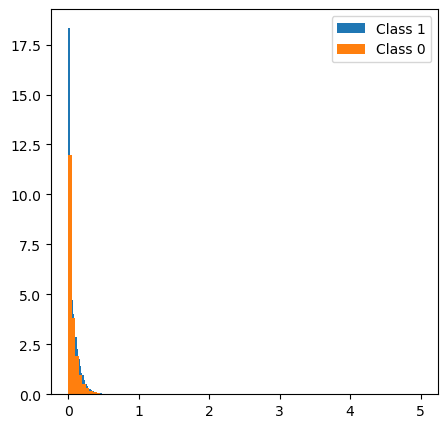

In [11]:
plt.figure(figsize=(5,5))
plt.hist(K[train_labels.astype(bool), :].ravel(), bins=100, density=True, label="Class 1")
plt.hist(K[~train_labels.astype(bool), :].ravel(), bins=100, density=True, label="Class 0")
plt.legend(loc='upper right')
plt.show()


In [12]:
neg, pos = np.bincount(train_labels.astype(int))
neg_freq = neg/len(train_labels)
pos_freq = pos/len(train_labels)

idx_neg = np.argwhere(train_labels == 0).ravel()
idx_pos = np.argwhere(train_labels == 1).ravel()
fold_idx = {}

for fold in range(1, 5):
    idx_neg_fold = np.random.choice(idx_neg, neg*20//100, replace=False)
    idx_neg = np.setdiff1d(idx_neg, idx_neg_fold)
    idx_pos_fold = np.random.choice(idx_pos, pos*20//100, replace=False)
    idx_pos = np.setdiff1d(idx_pos, idx_pos_fold)
    fold_idx[fold] = np.sort(np.concatenate([idx_neg_fold, idx_pos_fold]))

fold_idx[5] = np.sort(np.concatenate([idx_pos, idx_neg]))

## With Pytorch

In [12]:
import copy

In [124]:
nb_epochs = 4000
batch_size = 128
lambda1 = 0.

In [13]:
def train(params, K_train, K_val, y_train, y_val, n_epochs):
    
    batch_size = params["batch_size"]
    lambda1 = params['lambda1']
    best_model = {}
    best_acc = 0
    acc_list = []
    loss_list_train = []
    
    # Tensors
    X_train = torch.FloatTensor(K_train)
    X_val = torch.FloatTensor(K_val)

    # Get weights (imbalance)
    w_neg = torch.sum(y_train == 0)
    w_pos = torch.sum(y_train == 1)
    
    # define model and optimizer
    n = K_train.shape[0]
    model = LogisticRegression(input_dim=n, output_dim=1)
    criterion = torch.nn.BCELoss(reduction='none') # gives vector output
    optimizer = torch.optim.SGD(model.parameters(),
                                lr=params['lr'])
    # Training
    for epoch in range(n_epochs):
        batch_loss = []
        for b in range(n//batch_size):
            X_batch = X_train[b*batch_size:(b+1)*batch_size, :]
            y_batch = y_train[b*batch_size:(b+1)*batch_size].reshape(-1, 1)

            # define weights to correct imbalanceness      
            weights = torch.FloatTensor([n/(2*w_neg) if val==0. else n/(2*w_pos) for val in y_batch])

            y_pred = model(X_batch)

            loss = torch.mean(criterion(y_pred, y_batch)*weights)
            for param in model.linear.parameters():
                loss += lambda1*torch.norm(param, 1)

            batch_loss.append(loss.item())
            loss.backward()
            optimizer.step()

        loss_list_train.append(np.mean(batch_loss))


        with torch.no_grad():
            y_valpred = model(X_val).round()
            acc = f1_score(y_val, y_valpred.numpy()[:, 0])
            acc_list.append(acc)
            if acc > best_acc:
                best_acc = acc
                best_model = copy.deepcopy(model)

                print(f"New best acc={best_acc}")
    return {"params": params, 
            "best_acc": best_acc, 
            "best_model": best_model, 
            "loss_train": loss_list_train, 
            "acc_val": acc_list}

In [134]:
best_model = {}
fold = 1
best_acc = 0
acc_list = []
loss_list_train = []


print(f"\nProcessing fold {fold}")
idx_val = fold_idx[fold]
idx_train = np.setdiff1d(np.arange(len(train_labels)), idx_val)
K_train = K[idx_train, :][:, idx_train]

# Normalize
sc = StandardScaler()
# X_train = torch.FloatTensor(sc.fit_transform(K_train))
X_train = torch.FloatTensor(K_train)
K_val = K[idx_val, :][:, idx_train]
# X_val = torch.FloatTensor(sc.transform(K_val))
X_val = torch.FloatTensor(K_val)

# Get labels
y_train = torch.FloatTensor(train_labels[idx_train])
y_val = train_labels[idx_val]

w_neg = torch.sum(y_train == 0)
w_pos = torch.sum(y_train == 1)

n = K_train.shape[0]
model = LogisticRegression(input_dim=n, output_dim=1)
learning_rate = 5e-5
criterion = torch.nn.BCELoss(reduction='none') # gives vector output
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-5
                            )

for epoch in range(nb_epochs):
    batch_loss = []
    for b in range(n//batch_size):
        X_batch = X_train[b*batch_size:(b+1)*batch_size, :]
        y_batch = y_train[b*batch_size:(b+1)*batch_size].reshape(-1, 1)
        
        # define weights to correct imbalanceness      
        weights = torch.FloatTensor([n/(2*w_neg) if val==0. else n/(2*w_pos) for val in y_batch])
        
        y_pred = model(X_batch)
        
        loss = torch.mean(criterion(y_pred, y_batch)*weights)
        for param in model.linear.parameters():
            loss += lambda1*torch.norm(param, 1)
        
        batch_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        
    loss_list_train.append(np.mean(batch_loss))


    with torch.no_grad():
        y_valpred = model(X_val).round()
        acc = f1_score(y_val, y_valpred.numpy()[:, 0])
        acc_list.append(acc)
        if acc > best_acc:
            best_acc = acc
            best_model = copy.deepcopy(model)
            
            print(f"New best acc={best_acc}")


Processing fold 1
New best acc=0.011904761904761906
New best acc=0.016260162601626015
New best acc=0.11851851851851852
New best acc=0.17964071856287428
New best acc=0.22702702702702704
New best acc=0.2524271844660194
New best acc=0.2727272727272727
New best acc=0.29694323144104806
New best acc=0.3096234309623431
New best acc=0.31020408163265306
New best acc=0.31413612565445026
New best acc=0.32291666666666663
New best acc=0.3263157894736842
New best acc=0.32978723404255317
New best acc=0.3315508021390374
New best acc=0.33695652173913043
New best acc=0.33898305084745767
New best acc=0.348314606741573
New best acc=0.35028248587570615
New best acc=0.3595505617977528
New best acc=0.3657142857142857
New best acc=0.384180790960452
New best acc=0.3885714285714285
New best acc=0.39306358381502887
New best acc=0.3953488372093023
New best acc=0.39548022598870053
New best acc=0.3977272727272727
New best acc=0.4022988505747127
New best acc=0.4114285714285715
New best acc=0.4180790960451978
New be

KeyboardInterrupt: 

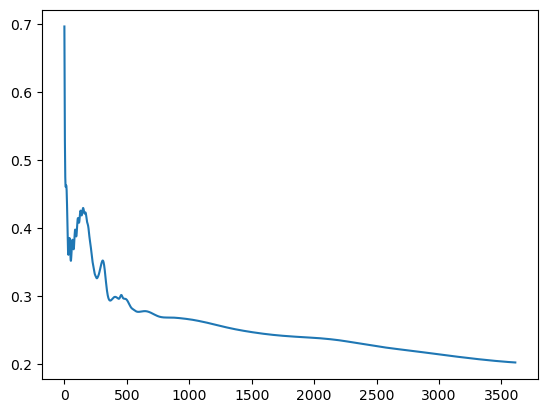

In [135]:
plt.plot(loss_list_train)
plt.show()

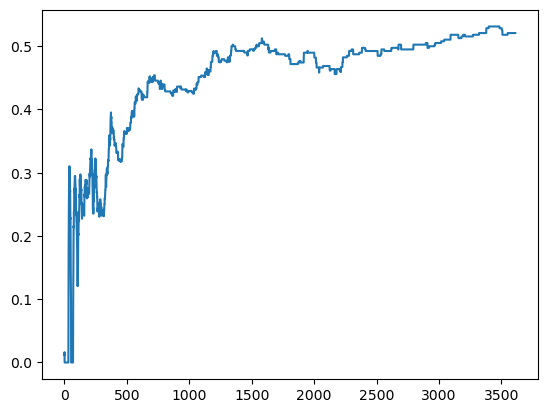

In [136]:
plt.plot(acc_list)
plt.show()

In [129]:
X_test = torch.FloatTensor(K_test[:, idx_train])

In [130]:
with torch.no_grad():
    test = model(X_test).round()

In [131]:
np.unique(test, return_counts=True)

(array([0., 1.], dtype=float32), array([1687,  313]))

### CrossValidation to get best hyperparameters

In [14]:
all_lr = [1e-3, 1e-4, 1e-5, 5e-6]
all_lambda1 = [0, 1e-4, 0.001, 0.1]
all_batch_sizes = [128, 256]
n_epochs = 4000

In [15]:
neg, pos = np.bincount(train_labels.astype(int))
neg_freq = neg/len(train_labels)
pos_freq = pos/len(train_labels)

idx_neg = np.argwhere(train_labels == 0).ravel()
idx_pos = np.argwhere(train_labels == 1).ravel()
fold_idx = {}

for fold in range(1, 2):
    idx_neg_fold = np.random.choice(idx_neg, neg*50//100, replace=False)
    idx_neg = np.setdiff1d(idx_neg, idx_neg_fold)
    idx_pos_fold = np.random.choice(idx_pos, pos*50//100, replace=False)
    idx_pos = np.setdiff1d(idx_pos, idx_pos_fold)
    fold_idx[fold] = np.sort(np.concatenate([idx_neg_fold, idx_pos_fold]))

fold_idx[2] = np.sort(np.concatenate([idx_pos, idx_neg]))

In [16]:
from itertools import product

In [ ]:
res_gridsearch = {}
for idx, (lr, lambda1, batch_size) in enumerate(product(all_lr, all_lambda1, all_batch_sizes)):
    params = {'lr': lr, 'batch_size': batch_size, 'lambda1': lambda1}
    print(f"Testing params {params}")
    
    #Perform crossval
    res_params = {}
    for fold in fold_idx:
        print(f"\nProcessing fold {fold}")
        idx_val = fold_idx[fold]
        idx_train = np.setdiff1d(np.arange(len(train_labels)), idx_val)
        K_train = K[idx_train, :][:, idx_train]
        K_val = K[idx_val, :][:, idx_train]

        # Get labels
        y_train = torch.FloatTensor(train_labels[idx_train])
        y_val = train_labels[idx_val]
        
        res = train(params, K_train, K_val, y_train, y_val, n_epochs)
        print(f"Results {res['best_acc']}\n")
        res_params[fold] = res
    
    res_gridsearch[idx] = np.mean([v['best_acc'] for v in res_params.values()])

Testing params {'lr': 0.001, 'batch_size': 128, 'lambda1': 0}

Processing fold 1
New best acc=0.37037037037037035
New best acc=0.375
New best acc=0.39592430858806404
New best acc=0.4293193717277487
New best acc=0.45482866043613707
New best acc=0.4549237170596394
New best acc=0.4620938628158845
New best acc=0.46808510638297873
New best acc=0.46987951807228917
New best acc=0.47987616099071206
New best acc=0.4875621890547263
New best acc=0.48837209302325585
New best acc=0.4985835694050992
New best acc=0.5
New best acc=0.5009074410163339
New best acc=0.5014409221902018
New best acc=0.5039370078740157
New best acc=0.5141903171953256
New best acc=0.5180722891566265
New best acc=0.5469522240527184
New best acc=0.5547703180212014
New best acc=0.5593869731800767
New best acc=0.5719237435008666
New best acc=0.5802919708029198
New best acc=0.5806451612903226
New best acc=0.5840407470288624
New best acc=0.5852713178294573


In [171]:
res_gridsearch

{0: {'mean_acc': 0.35560442489670796},
 1: {'mean_acc': 0.3273595672686648},
 2: {'mean_acc': 0.356790702920619},
 3: {'mean_acc': 0.3357927862503026},
 4: {'mean_acc': 0.07478260869565219},
 5: {'mean_acc': 0.006006006006006007},
 6: {'mean_acc': 0.25319619886682704},
 7: {'mean_acc': 0.24441741260466657},
 8: {'mean_acc': 0.016655725563466815},
 9: {'mean_acc': 0.01785569651942773},
 10: {'mean_acc': 0.012704686617730096},
 11: {'mean_acc': 0.02261199019389347},
 12: {'mean_acc': 0.02768499000054051},
 13: {'mean_acc': 0.10364323909703173},
 14: {'mean_acc': 0.12969866676158723},
 15: {'mean_acc': 0.2583342933042898},
 16: {'mean_acc': 0.12932426607304848},
 17: {'mean_acc': 0.06964206865627706},
 18: {'mean_acc': 0.160932779685282},
 19: {'mean_acc': 0.1605409627966019},
 20: {'mean_acc': 0.12416933300516858},
 21: {'mean_acc': 0.03863468003874865},
 22: {'mean_acc': 0.11333385942760943},
 23: {'mean_acc': 0.03160658307210031},
 24: {'mean_acc': 0.25773507707369336},
 25: {'mean_acc


Processing fold 1


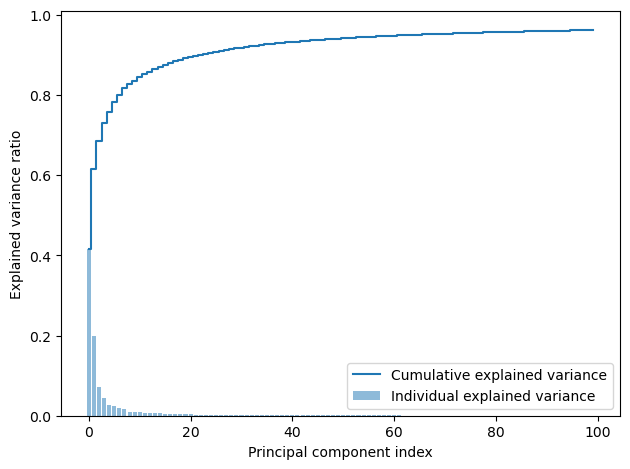

(4800, 4800) (4800, 1200)
Finished PCA
4800 100
                                     CVXPY                                     
                                     v1.2.2                                    
(CVXPY) Apr 05 04:19:34 PM: Your problem has 100 variables, 0 constraints, and 1 parameters.
(CVXPY) Apr 05 04:19:34 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 05 04:19:34 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 05 04:19:34 PM: Compiling problem (target solver=ECOS).
(CVXPY) Apr 05 04:19:34 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) Apr 05 04:19:34 PM: Applying reduction FlipObjective

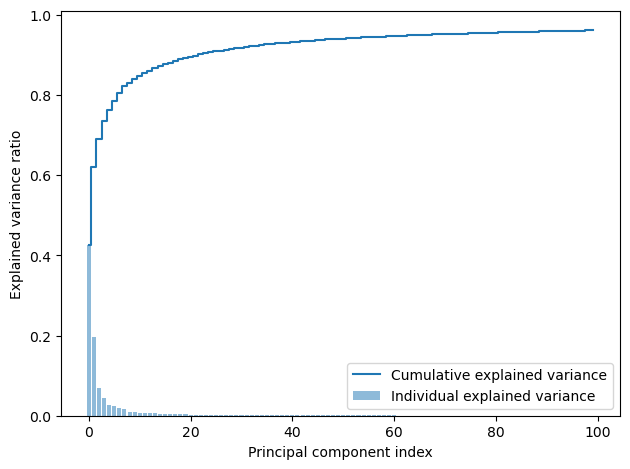

(4800, 4800) (4800, 1200)
Finished PCA
4800 100
                                     CVXPY                                     
                                     v1.2.2                                    
(CVXPY) Apr 05 04:19:45 PM: Your problem has 100 variables, 0 constraints, and 1 parameters.
(CVXPY) Apr 05 04:19:45 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 05 04:19:45 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 05 04:19:45 PM: Compiling problem (target solver=ECOS).
(CVXPY) Apr 05 04:19:45 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) Apr 05 04:19:45 PM: Applying reduction FlipObjective

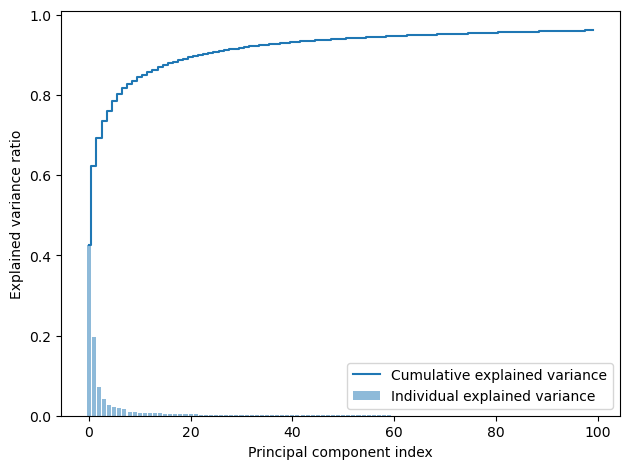

(4800, 4800) (4800, 1200)
Finished PCA
4800 100
                                     CVXPY                                     
                                     v1.2.2                                    
(CVXPY) Apr 05 04:19:57 PM: Your problem has 100 variables, 0 constraints, and 1 parameters.
(CVXPY) Apr 05 04:19:57 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 05 04:19:57 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 05 04:19:57 PM: Compiling problem (target solver=ECOS).
(CVXPY) Apr 05 04:19:57 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) Apr 05 04:19:57 PM: Applying reduction FlipObjective

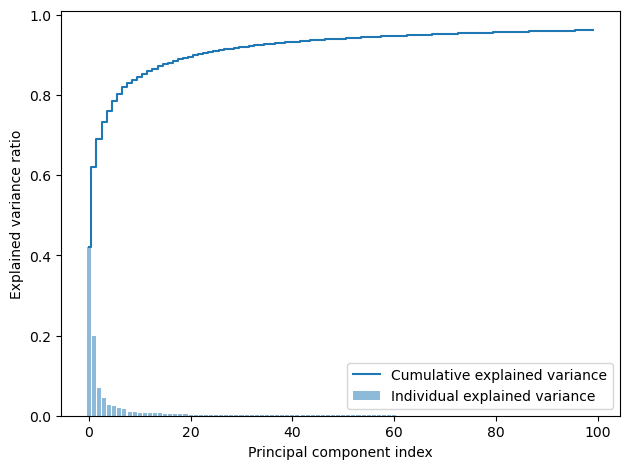

(4800, 4800) (4800, 1200)
Finished PCA
4800 100
                                     CVXPY                                     
                                     v1.2.2                                    
(CVXPY) Apr 05 04:20:08 PM: Your problem has 100 variables, 0 constraints, and 1 parameters.
(CVXPY) Apr 05 04:20:08 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 05 04:20:08 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 05 04:20:08 PM: Compiling problem (target solver=ECOS).
(CVXPY) Apr 05 04:20:08 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) Apr 05 04:20:08 PM: Applying reduction FlipObjective

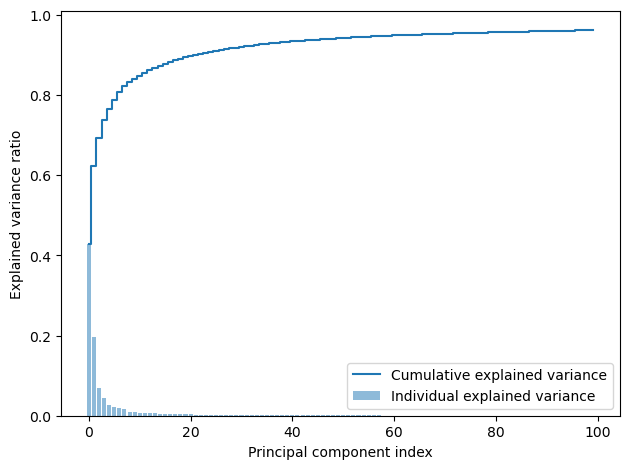

(4800, 4800) (4800, 1200)
Finished PCA
4800 100
                                     CVXPY                                     
                                     v1.2.2                                    
(CVXPY) Apr 05 04:20:19 PM: Your problem has 100 variables, 0 constraints, and 1 parameters.
(CVXPY) Apr 05 04:20:19 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 05 04:20:19 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 05 04:20:19 PM: Compiling problem (target solver=ECOS).
(CVXPY) Apr 05 04:20:19 PM: Reduction chain: FlipObjective -> Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> ECOS
(CVXPY) Apr 05 04:20:19 PM: Applying reduction FlipObjective

SolverError: Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.

In [27]:
## Kernel CVXOPT
res_folds = {}
for fold in fold_idx:
    print(f"\nProcessing fold {fold}")
    idx_val = fold_idx[fold]
    idx_train = np.setdiff1d(np.arange(len(train_labels)), idx_val)
    K_train = K[idx_train, :][:, idx_train]
    K_val = K[idx_train, :][:, idx_val]
    
    sc = StandardScaler()
    X_train = sc.fit_transform(K_train)
    X_val = sc.transform(K_val.T)
    
    pca = PCA(n_components=100)
    X_train = pca.fit_transform(X_train)
    X_val = pca.transform(X_val)
    
    exp_var_pca = pca.explained_variance_ratio_
    cum_sum_eigenvalues = np.cumsum(exp_var_pca)
    plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    print(K_train.shape, K_val.shape)
    print('Finished PCA')

    log = KernelLRCVX()
    log.fit(X_train, train_labels[idx_train])
    
    # validation
    val_pred = log.predict(X_val)
    acc = f1_score(train_labels[idx_val], val_pred, average="macro")
    res_folds[fold] = {"acc": acc, "params": log.param_opt}
    print(f"Results : acc={acc}")

## Gradient descent


Processing fold 1
Results : acc=0.5965676229508197


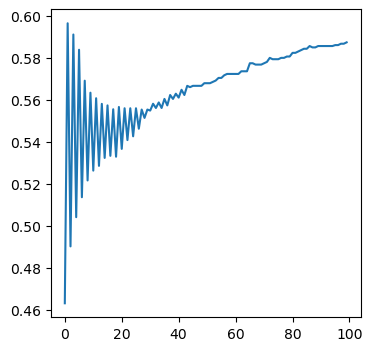


Processing fold 2
Results : acc=0.5970869527068527


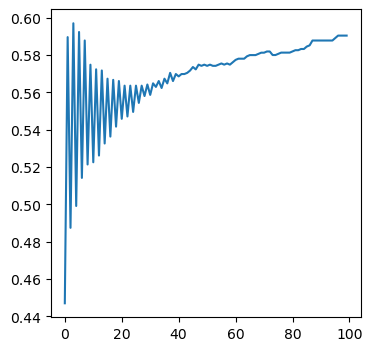


Processing fold 3


KeyboardInterrupt: 

In [37]:
res_folds = {}
for fold in fold_idx:
    print(f"\nProcessing fold {fold}")
    idx_val = fold_idx[fold]
    idx_train = np.setdiff1d(np.arange(len(train_labels)), idx_val)
    K_train = K[idx_train, :][:, idx_train]
    K_val = K[idx_train, :][:, idx_val]

    log = KernelLR(learning_rate=5e-5, regul=1)
    log.fit(K_train, train_labels[idx_train], K_val, train_labels[idx_val], n_iter=100)
    
    res_folds[fold] = {"acc": log.accuracy, "params": log.param_opt, "acc_list":log.acc_list, "last_params":log.param}
    print(f"Results : acc={log.accuracy}")
    plt.figure(figsize=(4,4))
    plt.plot(log.acc_list)
    plt.show()

In [22]:
# get model with best performance on validation data
acc_folds = [res_folds[fold]['acc'] for fold in res_folds]
best_fold = list(fold_idx.keys())[np.argmax(acc_folds)]
best_param = res_folds[best_fold]['params']
best_acc = res_folds[best_fold]['acc']
best_acc_list = res_folds[best_fold]["acc_list"]
last_param = res_folds[best_fold]['last_params']
print(f"Best fold is {best_fold} with macro f1 score {best_acc}")

KeyError: 'acc_list'

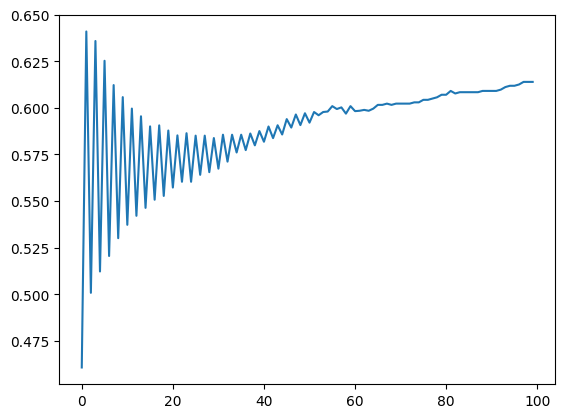

In [142]:
plt.plot(best_acc_list)

In [143]:
# Apply on validation again
idx_best_val = fold_idx[best_fold]
idx_best_train = np.setdiff1d(np.arange(len(train_labels)), idx_best_val)
K_best_val = K[idx_best_train,:][:, idx_best_val]
log = KernelLR(learning_rate=.5)
log.param_opt = best_param
best_val = log.predict(K_best_val)
print(classification_report(train_labels[idx_best_val], best_val))
log.param_opt = last_param
last_val = log.predict(K_best_val)
print(classification_report(train_labels[idx_best_val], last_val))

              precision    recall  f1-score   support

           0       0.96      0.81      0.88      1089
           1       0.28      0.70      0.40       111

    accuracy                           0.80      1200
   macro avg       0.62      0.76      0.64      1200
weighted avg       0.90      0.80      0.84      1200

              precision    recall  f1-score   support

           0       0.98      0.74      0.84      1089
           1       0.25      0.86      0.39       111

    accuracy                           0.75      1200
   macro avg       0.61      0.80      0.61      1200
weighted avg       0.91      0.75      0.80      1200



In [134]:
test = log.predict(K_test.T[idx_best_train,:])

In [136]:
np.unique(test, return_counts=True)

(array([0, 1]), array([1814,  186]))

In [30]:
test_preds = test.copy()
test_preds[test_preds == -1] = 0
Yte = {'Predicted' : test_preds}
dataframe = pd.DataFrame(Yte) 
dataframe.index += 1 
dataframe.to_csv('test_pred_klr_5folds.csv',index_label='Id')

## Kernel Perceptron

In [11]:
kernel_mat = WLKernel(iterations=5).compute_kernel_matrix

Processing fold 1
Results : acc=0.759957695514655


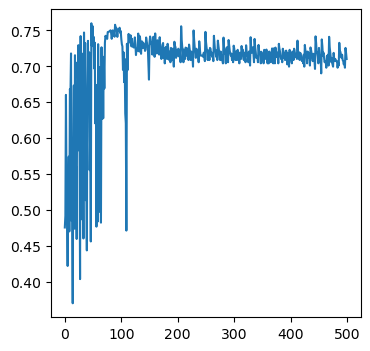

Processing fold 2
Results : acc=0.8043644229545743


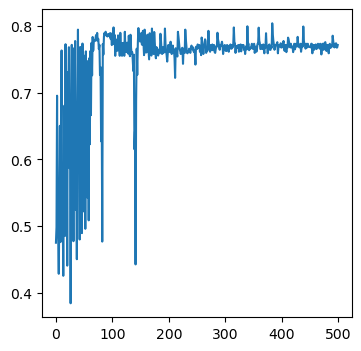

Processing fold 3
Results : acc=0.7405372405372406


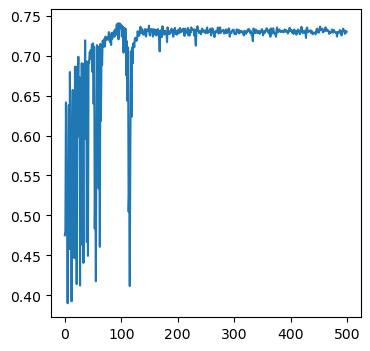

Processing fold 4
Results : acc=0.8028451212181927


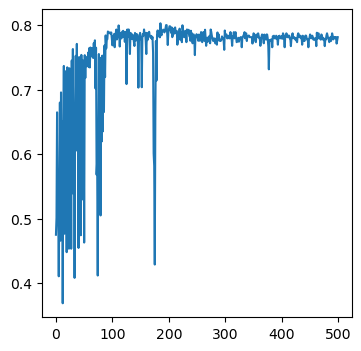

Processing fold 5
Results : acc=0.7789709473550783


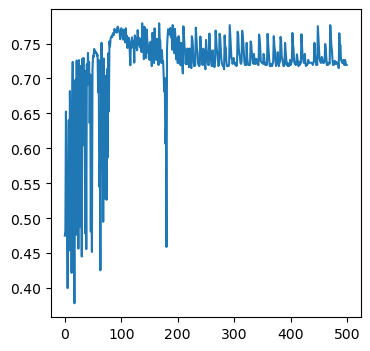

In [12]:
per_folds = {}
for fold in fold_idx:
    print(f"Processing fold {fold}")
    idx_val = fold_idx[fold]
    idx_train = np.setdiff1d(np.arange(len(train_labels)), idx_val)
    
    K_train = K[idx_train, :][:, idx_train]
    K_val = K[idx_train, :][:, idx_val]
    per = KernelPerceptron(kernel_mat=kernel_mat, epsilon=1e-5, n_iter=500)
    per.fit(X=train_data[idx_train], 
            y=train_labels_svm[idx_train], 
            K=K_train, 
            valX=train_data[idx_val], 
            valY=train_labels_svm[idx_val], 
            K_val=K_val)
    per_folds[fold] = {"acc": per.accuracy, "params": per.opt_alpha, "acc_list":per.acc_list}
    print(f"Results : acc={per.accuracy}")
    plt.figure(figsize=(4,4))
    plt.plot(per.acc_list)
    plt.show()

In [13]:
# get model with best performance on validation data
acc_list = [per_folds[fold]['acc'] for fold in per_folds]
best_fold = list(fold_idx.keys())[np.argmax(acc_list)]
best_param = per_folds[best_fold]['params']
best_acc = per_folds[best_fold]['acc']
best_acc_list = per_folds[best_fold]['acc_list']
print(f"Best fold is {best_fold} with macro f1 score {best_acc}")

Best fold is 2 with macro f1 score 0.8043644229545743


In [14]:
# Apply on validation again
idx_best_val = fold_idx[best_fold]
idx_best_train = np.setdiff1d(np.arange(len(train_labels)), idx_best_val)
K_best_val = K[idx_best_train,:][:, idx_best_val]
per = KernelPerceptron(kernel_mat=kernel_mat, epsilon=1e-5, n_iter=100)
per.opt_alpha = best_param
best_val = per.predict(train_data[idx_best_val], K_best_val)
print(classification_report(train_labels_svm[idx_best_val], best_val))

              precision    recall  f1-score   support

          -1       0.97      0.96      0.96      1089
           1       0.62      0.68      0.65       111

    accuracy                           0.93      1200
   macro avg       0.79      0.82      0.80      1200
weighted avg       0.93      0.93      0.93      1200



In [15]:
per = KernelPerceptron(kernel_mat=kernel_mat, epsilon=1e-5, n_iter=250)
per.fit(X=train_data, 
        y=train_labels_svm, 
        K=K)

In [16]:
test = per.predict(test_data, K_test.T)

In [17]:
np.unique(test, return_counts=True)

(array([-1.,  1.]), array([1715,  285]))

In [24]:
prev = pd.read_csv("test_pred.csv")
prev["Predicted"].sum()

347.0